<a href="https://colab.research.google.com/github/Pankaj1357/HC18-Grand-Challenge/blob/master/HC18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd

# **Mask Generation**
Done only once and replaced that  annotation with masks permanently
Did not changed the annotation file name though

## **Warning!!!**
Do not run below cells as task is already completed

In [2]:
train_pixel_file = pd.read_csv('training_set_pixel_size_and_HC.csv')
train_pixel_file.head()
# This Dataframe will be used to extract image names hence by doing image_name + '_Annotation' we will get annotation names

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [3]:
# This function takes annotation and spits out corresponding mask
# Receive Edge Files and do Gaussian Blur here. 
def masking(image):
    return cv2.GaussianBlur(image,(31,31), 2, 2, cv2.BORDER_CONSTANT)

training_set/000_HC_Annotation.png
training_set/001_HC_Annotation.png
training_set/002_HC_Annotation.png
training_set/003_HC_Annotation.png
training_set/004_HC_Annotation.png
training_set/005_HC_Annotation.png
training_set/006_HC_Annotation.png


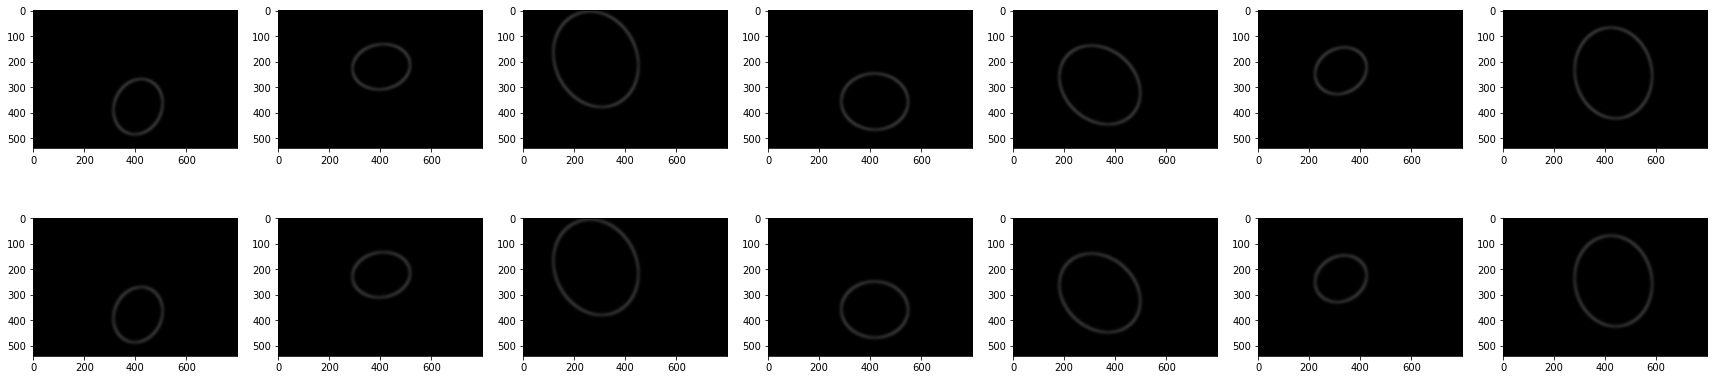

In [4]:
# to check if our masking function is working correctly
fig = plt.figure(figsize = (30,7))
for index in range(7):
  file_path = os.path.join('training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
  print(file_path)
  ax = fig.add_subplot(2, 7, index+1)             ## annoted plot
  plt.imshow(cv2.imread(file_path))
    
  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(masking(cv2.imread(file_path)))        ## mask plot

In [5]:
# Here we loop through training set and  take annotations one by one and replace them with corresponding masks
fig = plt.figure(figsize = (30,7))
for index in range(len(train_pixel_file)):
    file_path = os.path.join('training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
    image = cv2.imread(file_path)
    mask = masking(image)
    cv2.imwrite(file_path, mask)


<Figure size 2160x504 with 0 Axes>

## **Warning!!!**
**Done with mask generation. Don't run above cells ever again**

### **Do all the imports in below cell**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from skimage import io, color
from PIL import Image
import cv2

import os
import random

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [7]:
validation_set_size = 0.20            # fraction of dataset used for validation which will be splited randomly

In [8]:
# our dataset class
class HC18(Dataset):
  #""" train and validation dataset class"""
    def __init__(self, root_dir, train = True, transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'training_set_pixel_size_and_HC.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        
        # lets split the dataset in train and validation
        self.train_data, self.validation_data = train_test_split(self.pixel_file, test_size = validation_set_size, random_state = 5)
        
    def __len__(self):
        
        if self.train:
          length = len(self.train_data)
        else:
          length = len(self.validation_data)
        return length
    
    def __getitem__(self, index):
      
        if self.train:
          imx_name = os.path.join(self.root_dir, 'training_set', self.train_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'training_set',self.train_data.iloc[index, 0].replace('.png','_Annotation.png'))

        else:
          imx_name = os.path.join(self.root_dir, 'training_set', self.validation_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'training_set',self.validation_data.iloc[index, 0].replace('.png','_Annotation.png'))
        
        
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')
        
        ## tried some data augmentation techniques
        if self.train:
          # Random horizontal flipping
          if random.random() > 0.5:
              imx = TF.hflip(imx)
              imy = TF.hflip(imy)

          # Random vertical flipping
          if random.random() > 0.5:
              imx = TF.vflip(imx)
              imy = TF.vflip(imy)


          # Random rotation
          if random.random() > 0.8:
            angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
            imx = TF.rotate(imx, angle)
            imy = TF.rotate(imy, angle)
        
        
        
        
        
        
        if self.transformX :
            imx = self.transformX(imx)
            imy = self.transformY(imy)
        
        sample = {'image': imx, 'annotation': imy}
        return sample

In [9]:
# our datasets
tx_X = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])
tx_Y = transforms.Compose([ transforms.Resize((572, 572)),
                            transforms.ToTensor(),  ################ no need to normalize the maskk
                             # transforms.Normalize((0.5,), (0.5,))
                              ])
train_data = HC18('', train = True, transformX = tx_X, transformY = tx_Y)
validation_data = HC18('', train = False, transformX = tx_X, transformY = tx_Y )

In [10]:
# our dataloaders
train_loader = DataLoader(dataset = train_data, batch_size = 2, shuffle = True, num_workers = 2 )
validation_loader = DataLoader(dataset = validation_data, batch_size = 2, shuffle = True, num_workers = 2)

In [11]:
# this function will return numpy array from the transformed tensors which were
# obtained from our train_loader. Just to plot them and see if they are intact :) ha ha
def im_converterX(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # unnormalizing the image # this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

In [12]:
# this function will return numpy array from the transformed tensors which were
# obtained from our train_loader. Just to plot them and see if they are intact :) ha ha
def im_converterY(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    image = image * np.array((1, 1, 1)) # unnormalizing the image  not needed# this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

0 torch.Size([2, 1, 572, 572]) torch.Size([2, 1, 572, 572])


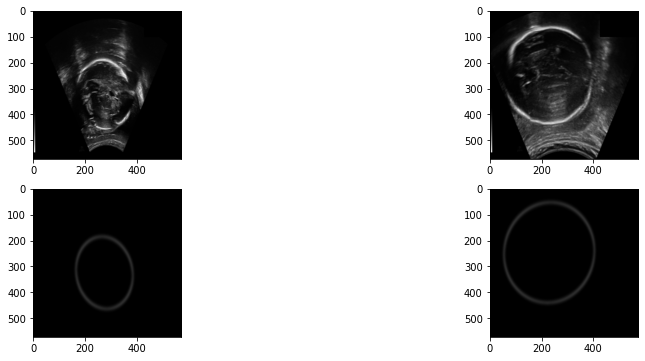

In [13]:
## Here we loop through our train_loader and see the images
## Looks good
fig = plt.figure(figsize = (15,6))
for ith_batch, sample_batched in enumerate(train_loader):
    print(ith_batch, sample_batched['image'].size(), sample_batched['annotation'].size())
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(sample_batched['image'][index]))
        ax = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(sample_batched['annotation'][index]))
    break

In [14]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.7),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.77),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear: #upsampling will not be learnable
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:  # it will be learnable here
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
        
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [15]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, bilinear = False) # upsampling weights are made learnable
        self.up2 = up(512, 128, bilinear = False)
        self.up3 = up(256, 64, bilinear = False)
        self.up4 = up(128, 64, bilinear = False)
        self.outc = outconv(64, n_classes)
        self.dropout = torch.nn.Dropout2d(0.1)

    def forward(self, x):
        x = x.float()
        x1 = self.inc(x)
        x1 = self.dropout(x1)
        x2 = self.down1(x1)
        x2 = self.dropout(x2)
        x3 = self.down2(x2)
        x3 = self.dropout(x3)
        x4 = self.down3(x3)
        x4 = self.dropout(x4)
        x5 = self.down4(x4)
       
        x = self.up1(x5, x4)
#         print(x.shape)
        x = self.up2(x, x3)
#         print(x.shape)
        x = self.dropout(x)
        x = self.up3(x, x2)
#         print(x.shape)
        #x = self.dropout(x) #
        x = self.up4(x, x1)
#         print(x.shape)
        x = self.outc(x)
#         print(x.shape)
        return torch.sigmoid(x)
      
      
      
      
      
      
model = UNet(1, 1)
model.to('cuda')
print("Model Loaded to GPU")

Model Loaded to GPU


In [16]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0077)

In [17]:
# calculates similarity index between predicted and actual segmentation
def dice_index(y_pred, y_actual):
    smooth = 0.000001
    size_of_batch = y_pred.size(0)
    
    p1 = y_pred.view(size_of_batch, -1)
 
    p2 = y_actual.view(size_of_batch, -1)
    
    intersection = (p1 * p2).sum()
    
    dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)
    #dice.requires_grad = True
    
    return dice

In [18]:
# calculate dice loss which will be later used in loss function calculation
def dice_loss(y_predict, y_train): ## to add in bce looss
  
  dice_loss = 1 -(dice_index(y_predict, y_train))
  
  return dice_loss
  

In [19]:
epochs = 200


train_running_loss_history = []
validation_running_loss_history =[]

for e in range(epochs):
  train_running_loss = 0.0
  validation_running_loss = 0.0
  
  model.train()
  
  for ith_batch, sample_batched in enumerate(train_loader):
    X_train = sample_batched['image'].to('cuda')
    y_train = sample_batched['annotation'].to('cuda')
    #X_train.requires_grad = True
    #y_train.requires_grad = True

    #print(ith_batch) #, X_train.size(), y_train.size())

    optimizer.zero_grad()
    y_pred = model(X_train)
   # out = (y_pred + 0.5).int().float()
    
    loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)
    #loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if ith_batch % 50 == 0:
      print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
      
    train_running_loss += loss.item()
    
    
    
    
  else:
    print('else')
    with torch.no_grad():
      
      model.eval()
      
      for ith_batch, sample_batched in enumerate(validation_loader):
          X_val = sample_batched['image'].to('cuda')
          y_val = sample_batched['annotation'].to('cuda')
          
          
          
          y_out = model(X_val)
          out_val = (y_out + 0.5).int().float()
          
          val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)
          
          #val_loss = criterion(y_out, y_val)
          
          validation_running_loss += val_loss.item()
      print("================================================================================")
      print("Epoch {} completed".format(e + 1))
      
      train_epoch_loss = train_running_loss / len(train_loader)
      validation_epoch_loss = validation_running_loss / len(validation_loader)
      
      print("Average train loss is {}: ".format(train_epoch_loss))
      print("Average validation loss is {}".format(validation_epoch_loss))
      print("================================================================================")
      train_running_loss_history.append(train_epoch_loss)
      validation_running_loss_history.append(validation_epoch_loss)
  
  torch.cuda.empty_cache()
      #print(y_pred.shape)

    #y_pred = y_pred.to('cpu')
    #X_train = X_train.to('cpu')

    #del y_train
    #torch.cuda.empty_cache()
    #if ith_batch ==100:
    #break
  #for index in range(2):
  #         ax = gig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
   #         plt.imshow(im_converter(X_train[index]))
    #        ax = gig.add_subplot(2, 2, index + 3)
     #       plt.imshow(im_converter(y_pred[index]))
  
    
  
   
  

  
  
torch.save(model,"Models/Unet_GB_31_2.pt") 
    

Epoch:  1 Batch:  0 Current Loss:  0.7377043962478638
Epoch:  1 Batch:  50 Current Loss:  0.31315717101097107
Epoch:  1 Batch:  100 Current Loss:  0.30631089210510254
Epoch:  1 Batch:  150 Current Loss:  0.3074329197406769
Epoch:  1 Batch:  200 Current Loss:  0.30018237233161926
Epoch:  1 Batch:  250 Current Loss:  0.30607879161834717
Epoch:  1 Batch:  300 Current Loss:  0.3060339093208313
Epoch:  1 Batch:  350 Current Loss:  0.30770811438560486
else
Epoch 1 completed
Average train loss is 0.3104135060310364: 
Average validation loss is 0.31337956577539444
Epoch:  2 Batch:  0 Current Loss:  0.2992168664932251
Epoch:  2 Batch:  50 Current Loss:  0.28437381982803345
Epoch:  2 Batch:  100 Current Loss:  0.2966219186782837
Epoch:  2 Batch:  150 Current Loss:  0.2922556698322296
Epoch:  2 Batch:  200 Current Loss:  0.29156866669654846
Epoch:  2 Batch:  250 Current Loss:  0.29432350397109985
Epoch:  2 Batch:  300 Current Loss:  0.288585364818573
Epoch:  2 Batch:  350 Current Loss:  0.2835386

Epoch:  12 Batch:  200 Current Loss:  0.3012499213218689
Epoch:  12 Batch:  250 Current Loss:  0.2870151102542877
Epoch:  12 Batch:  300 Current Loss:  0.2922534644603729
Epoch:  12 Batch:  350 Current Loss:  0.27650120854377747
else
Epoch 12 completed
Average train loss is 0.28353132426738736: 
Average validation loss is 0.27917199313640595
Epoch:  13 Batch:  0 Current Loss:  0.2748258411884308
Epoch:  13 Batch:  50 Current Loss:  0.26929256319999695
Epoch:  13 Batch:  100 Current Loss:  0.26928529143333435
Epoch:  13 Batch:  150 Current Loss:  0.2844060957431793
Epoch:  13 Batch:  200 Current Loss:  0.2793544828891754
Epoch:  13 Batch:  250 Current Loss:  0.28519585728645325
Epoch:  13 Batch:  300 Current Loss:  0.2808908224105835
Epoch:  13 Batch:  350 Current Loss:  0.28572869300842285
else
Epoch 13 completed
Average train loss is 0.2830188577622175: 
Average validation loss is 0.28413601607084277
Epoch:  14 Batch:  0 Current Loss:  0.28389590978622437
Epoch:  14 Batch:  50 Current

Epoch:  23 Batch:  350 Current Loss:  0.2833787798881531
else
Epoch 23 completed
Average train loss is 0.28122457668185236: 
Average validation loss is 0.28186681926250456
Epoch:  24 Batch:  0 Current Loss:  0.28892242908477783
Epoch:  24 Batch:  50 Current Loss:  0.2828095555305481
Epoch:  24 Batch:  100 Current Loss:  0.27099648118019104
Epoch:  24 Batch:  150 Current Loss:  0.2787989675998688
Epoch:  24 Batch:  200 Current Loss:  0.2893719971179962
Epoch:  24 Batch:  250 Current Loss:  0.28535541892051697
Epoch:  24 Batch:  300 Current Loss:  0.2823382616043091
Epoch:  24 Batch:  350 Current Loss:  0.27643832564353943
else
Epoch 24 completed
Average train loss is 0.28092691488564014: 
Average validation loss is 0.2800200200080872
Epoch:  25 Batch:  0 Current Loss:  0.288405179977417
Epoch:  25 Batch:  50 Current Loss:  0.29337435960769653
Epoch:  25 Batch:  100 Current Loss:  0.2805653214454651
Epoch:  25 Batch:  150 Current Loss:  0.28452152013778687
Epoch:  25 Batch:  200 Current 

Epoch:  35 Batch:  0 Current Loss:  0.2778494656085968
Epoch:  35 Batch:  50 Current Loss:  0.2909534275531769
Epoch:  35 Batch:  100 Current Loss:  0.2850012481212616
Epoch:  35 Batch:  150 Current Loss:  0.27960917353630066
Epoch:  35 Batch:  200 Current Loss:  0.27071911096572876
Epoch:  35 Batch:  250 Current Loss:  0.27711284160614014
Epoch:  35 Batch:  300 Current Loss:  0.26541635394096375
Epoch:  35 Batch:  350 Current Loss:  0.2777765691280365
else
Epoch 35 completed
Average train loss is 0.27932185277342797: 
Average validation loss is 0.2767642343044281
Epoch:  36 Batch:  0 Current Loss:  0.2769617438316345
Epoch:  36 Batch:  50 Current Loss:  0.28142791986465454
Epoch:  36 Batch:  100 Current Loss:  0.283358097076416
Epoch:  36 Batch:  150 Current Loss:  0.2819417417049408
Epoch:  36 Batch:  200 Current Loss:  0.2787686884403229
Epoch:  36 Batch:  250 Current Loss:  0.28157371282577515
Epoch:  36 Batch:  300 Current Loss:  0.2759486734867096
Epoch:  36 Batch:  350 Current L

Epoch:  46 Batch:  150 Current Loss:  0.26902809739112854
Epoch:  46 Batch:  200 Current Loss:  0.27516037225723267
Epoch:  46 Batch:  250 Current Loss:  0.27886897325515747
Epoch:  46 Batch:  300 Current Loss:  0.2685888409614563
Epoch:  46 Batch:  350 Current Loss:  0.2817123532295227
else
Epoch 46 completed
Average train loss is 0.2781221007555723: 
Average validation loss is 0.2769703170657158
Epoch:  47 Batch:  0 Current Loss:  0.2843969762325287
Epoch:  47 Batch:  50 Current Loss:  0.27526384592056274
Epoch:  47 Batch:  100 Current Loss:  0.27507442235946655
Epoch:  47 Batch:  150 Current Loss:  0.26297175884246826
Epoch:  47 Batch:  200 Current Loss:  0.27038800716400146
Epoch:  47 Batch:  250 Current Loss:  0.28089991211891174
Epoch:  47 Batch:  300 Current Loss:  0.28813084959983826
Epoch:  47 Batch:  350 Current Loss:  0.27596306800842285
else
Epoch 47 completed
Average train loss is 0.2779890353232622: 
Average validation loss is 0.2781444013118744
Epoch:  48 Batch:  0 Curre

Epoch:  57 Batch:  300 Current Loss:  0.2702484428882599
Epoch:  57 Batch:  350 Current Loss:  0.28399398922920227
else
Epoch 57 completed
Average train loss is 0.27661335572600365: 
Average validation loss is 0.2760257598757744
Epoch:  58 Batch:  0 Current Loss:  0.27786457538604736
Epoch:  58 Batch:  50 Current Loss:  0.2665237784385681
Epoch:  58 Batch:  100 Current Loss:  0.2849765121936798
Epoch:  58 Batch:  150 Current Loss:  0.2725656032562256
Epoch:  58 Batch:  200 Current Loss:  0.28562837839126587
Epoch:  58 Batch:  250 Current Loss:  0.27427738904953003
Epoch:  58 Batch:  300 Current Loss:  0.27168816328048706
Epoch:  58 Batch:  350 Current Loss:  0.2784654498100281
else
Epoch 58 completed
Average train loss is 0.2762820542603731: 
Average validation loss is 0.2784561637043953
Epoch:  59 Batch:  0 Current Loss:  0.2690950930118561
Epoch:  59 Batch:  50 Current Loss:  0.283300518989563
Epoch:  59 Batch:  100 Current Loss:  0.2660309076309204
Epoch:  59 Batch:  150 Current Los

Epoch:  69 Batch:  0 Current Loss:  0.27362877130508423
Epoch:  69 Batch:  50 Current Loss:  0.27897384762763977
Epoch:  69 Batch:  100 Current Loss:  0.27866822481155396
Epoch:  69 Batch:  150 Current Loss:  0.2822461724281311
Epoch:  69 Batch:  200 Current Loss:  0.266688734292984
Epoch:  69 Batch:  250 Current Loss:  0.2743476629257202
Epoch:  69 Batch:  300 Current Loss:  0.2757072150707245
Epoch:  69 Batch:  350 Current Loss:  0.2766415476799011
else
Epoch 69 completed
Average train loss is 0.2745183987170458: 
Average validation loss is 0.2784768897294998
Epoch:  70 Batch:  0 Current Loss:  0.28252851963043213
Epoch:  70 Batch:  50 Current Loss:  0.27162858843803406
Epoch:  70 Batch:  100 Current Loss:  0.2757306396961212
Epoch:  70 Batch:  150 Current Loss:  0.27387458086013794
Epoch:  70 Batch:  200 Current Loss:  0.2790091037750244
Epoch:  70 Batch:  250 Current Loss:  0.27586132287979126
Epoch:  70 Batch:  300 Current Loss:  0.27014875411987305
Epoch:  70 Batch:  350 Current 

Epoch:  80 Batch:  150 Current Loss:  0.2691432535648346
Epoch:  80 Batch:  200 Current Loss:  0.26986294984817505
Epoch:  80 Batch:  250 Current Loss:  0.2752535343170166
Epoch:  80 Batch:  300 Current Loss:  0.27118054032325745
Epoch:  80 Batch:  350 Current Loss:  0.2681215703487396
else
Epoch 80 completed
Average train loss is 0.27291515305638314: 
Average validation loss is 0.27832040637731553
Epoch:  81 Batch:  0 Current Loss:  0.2800379693508148
Epoch:  81 Batch:  50 Current Loss:  0.27005624771118164
Epoch:  81 Batch:  100 Current Loss:  0.27378010749816895
Epoch:  81 Batch:  150 Current Loss:  0.2708631157875061
Epoch:  81 Batch:  200 Current Loss:  0.2821572721004486
Epoch:  81 Batch:  250 Current Loss:  0.27008697390556335
Epoch:  81 Batch:  300 Current Loss:  0.2794877886772156
Epoch:  81 Batch:  350 Current Loss:  0.2811816334724426
else
Epoch 81 completed
Average train loss is 0.2729222433269024: 
Average validation loss is 0.2812096032500267
Epoch:  82 Batch:  0 Current 

Epoch:  91 Batch:  300 Current Loss:  0.26837342977523804
Epoch:  91 Batch:  350 Current Loss:  0.25990810990333557
else
Epoch 91 completed
Average train loss is 0.2710359197109938: 
Average validation loss is 0.28113335132598877
Epoch:  92 Batch:  0 Current Loss:  0.2651790678501129
Epoch:  92 Batch:  50 Current Loss:  0.2646174728870392
Epoch:  92 Batch:  100 Current Loss:  0.2804776430130005
Epoch:  92 Batch:  150 Current Loss:  0.2719970643520355
Epoch:  92 Batch:  200 Current Loss:  0.2587862014770508
Epoch:  92 Batch:  250 Current Loss:  0.27111300826072693
Epoch:  92 Batch:  300 Current Loss:  0.26142868399620056
Epoch:  92 Batch:  350 Current Loss:  0.268695592880249
else
Epoch 92 completed
Average train loss is 0.2712374669313431: 
Average validation loss is 0.2797823733091354
Epoch:  93 Batch:  0 Current Loss:  0.26532119512557983
Epoch:  93 Batch:  50 Current Loss:  0.26198333501815796
Epoch:  93 Batch:  100 Current Loss:  0.2547103464603424
Epoch:  93 Batch:  150 Current Lo

Epoch 102 completed
Average train loss is 0.2694256664812565: 
Average validation loss is 0.2793517020344734
Epoch:  103 Batch:  0 Current Loss:  0.2660927474498749
Epoch:  103 Batch:  50 Current Loss:  0.268373966217041
Epoch:  103 Batch:  100 Current Loss:  0.28025659918785095
Epoch:  103 Batch:  150 Current Loss:  0.26231256127357483
Epoch:  103 Batch:  200 Current Loss:  0.27098190784454346
Epoch:  103 Batch:  250 Current Loss:  0.2803039848804474
Epoch:  103 Batch:  300 Current Loss:  0.27884620428085327
Epoch:  103 Batch:  350 Current Loss:  0.2829756438732147
else
Epoch 103 completed
Average train loss is 0.2698228643834591: 
Average validation loss is 0.2789219856262207
Epoch:  104 Batch:  0 Current Loss:  0.27493178844451904
Epoch:  104 Batch:  50 Current Loss:  0.2723361551761627
Epoch:  104 Batch:  100 Current Loss:  0.26739591360092163
Epoch:  104 Batch:  150 Current Loss:  0.2693399488925934
Epoch:  104 Batch:  200 Current Loss:  0.2589806616306305
Epoch:  104 Batch:  250 

Epoch:  114 Batch:  0 Current Loss:  0.2642066180706024
Epoch:  114 Batch:  50 Current Loss:  0.27169856429100037
Epoch:  114 Batch:  100 Current Loss:  0.274995893239975
Epoch:  114 Batch:  150 Current Loss:  0.2744138240814209
Epoch:  114 Batch:  200 Current Loss:  0.2741214632987976
Epoch:  114 Batch:  250 Current Loss:  0.2688453197479248
Epoch:  114 Batch:  300 Current Loss:  0.27074864506721497
Epoch:  114 Batch:  350 Current Loss:  0.2728099524974823
else
Epoch 114 completed
Average train loss is 0.2684651429206133: 
Average validation loss is 0.2789642572402954
Epoch:  115 Batch:  0 Current Loss:  0.27356216311454773
Epoch:  115 Batch:  50 Current Loss:  0.26735955476760864
Epoch:  115 Batch:  100 Current Loss:  0.2718382477760315
Epoch:  115 Batch:  150 Current Loss:  0.2701926827430725
Epoch:  115 Batch:  200 Current Loss:  0.2838038206100464
Epoch:  115 Batch:  250 Current Loss:  0.2745053768157959
Epoch:  115 Batch:  300 Current Loss:  0.26944059133529663
Epoch:  115 Batch:

Epoch:  125 Batch:  50 Current Loss:  0.27520668506622314
Epoch:  125 Batch:  100 Current Loss:  0.26082590222358704
Epoch:  125 Batch:  150 Current Loss:  0.2643931210041046
Epoch:  125 Batch:  200 Current Loss:  0.25786131620407104
Epoch:  125 Batch:  250 Current Loss:  0.26733848452568054
Epoch:  125 Batch:  300 Current Loss:  0.265677809715271
Epoch:  125 Batch:  350 Current Loss:  0.26965075731277466
else
Epoch 125 completed
Average train loss is 0.2676662793010473: 
Average validation loss is 0.2801617532968521
Epoch:  126 Batch:  0 Current Loss:  0.267434298992157
Epoch:  126 Batch:  50 Current Loss:  0.2653547525405884
Epoch:  126 Batch:  100 Current Loss:  0.268446683883667
Epoch:  126 Batch:  150 Current Loss:  0.26541614532470703
Epoch:  126 Batch:  200 Current Loss:  0.27377671003341675
Epoch:  126 Batch:  250 Current Loss:  0.27104780077934265
Epoch:  126 Batch:  300 Current Loss:  0.26068785786628723
Epoch:  126 Batch:  350 Current Loss:  0.25560107827186584
else
Epoch 12

Epoch:  136 Batch:  100 Current Loss:  0.26731717586517334
Epoch:  136 Batch:  150 Current Loss:  0.2690030038356781
Epoch:  136 Batch:  200 Current Loss:  0.27275723218917847
Epoch:  136 Batch:  250 Current Loss:  0.27864721417427063
Epoch:  136 Batch:  300 Current Loss:  0.2757524251937866
Epoch:  136 Batch:  350 Current Loss:  0.26151302456855774
else
Epoch 136 completed
Average train loss is 0.267071934863925: 
Average validation loss is 0.279775367975235
Epoch:  137 Batch:  0 Current Loss:  0.2545543611049652
Epoch:  137 Batch:  50 Current Loss:  0.26522207260131836
Epoch:  137 Batch:  100 Current Loss:  0.26801180839538574
Epoch:  137 Batch:  150 Current Loss:  0.2671455442905426
Epoch:  137 Batch:  200 Current Loss:  0.26447412371635437
Epoch:  137 Batch:  250 Current Loss:  0.26925167441368103
Epoch:  137 Batch:  300 Current Loss:  0.26219117641448975
Epoch:  137 Batch:  350 Current Loss:  0.2715259790420532
else
Epoch 137 completed
Average train loss is 0.26732250429689886: 
A

Epoch:  147 Batch:  150 Current Loss:  0.2766217887401581
Epoch:  147 Batch:  200 Current Loss:  0.27943167090415955
Epoch:  147 Batch:  250 Current Loss:  0.25739315152168274
Epoch:  147 Batch:  300 Current Loss:  0.2773010730743408
Epoch:  147 Batch:  350 Current Loss:  0.26470696926116943
else
Epoch 147 completed
Average train loss is 0.2671490328758955: 
Average validation loss is 0.2806317722797394
Epoch:  148 Batch:  0 Current Loss:  0.2700316309928894
Epoch:  148 Batch:  50 Current Loss:  0.26260870695114136
Epoch:  148 Batch:  100 Current Loss:  0.266832172870636
Epoch:  148 Batch:  150 Current Loss:  0.2637411653995514
Epoch:  148 Batch:  200 Current Loss:  0.2653464376926422
Epoch:  148 Batch:  250 Current Loss:  0.2641860246658325
Epoch:  148 Batch:  300 Current Loss:  0.27397608757019043
Epoch:  148 Batch:  350 Current Loss:  0.2678278982639313
else
Epoch 148 completed
Average train loss is 0.26652863442897795: 
Average validation loss is 0.280241482257843
Epoch:  149 Batch

Epoch:  158 Batch:  200 Current Loss:  0.2781423330307007
Epoch:  158 Batch:  250 Current Loss:  0.2677742540836334
Epoch:  158 Batch:  300 Current Loss:  0.2649375796318054
Epoch:  158 Batch:  350 Current Loss:  0.2667568325996399
else
Epoch 158 completed
Average train loss is 0.2671153753250837: 
Average validation loss is 0.2792848163843155
Epoch:  159 Batch:  0 Current Loss:  0.2654431164264679
Epoch:  159 Batch:  50 Current Loss:  0.27031803131103516
Epoch:  159 Batch:  100 Current Loss:  0.26107272505760193
Epoch:  159 Batch:  150 Current Loss:  0.26668423414230347
Epoch:  159 Batch:  200 Current Loss:  0.2641419768333435
Epoch:  159 Batch:  250 Current Loss:  0.27039647102355957
Epoch:  159 Batch:  300 Current Loss:  0.284251868724823
Epoch:  159 Batch:  350 Current Loss:  0.2579699754714966
else
Epoch 159 completed
Average train loss is 0.26660065941512584: 
Average validation loss is 0.2800763353705406
Epoch:  160 Batch:  0 Current Loss:  0.26480844616889954
Epoch:  160 Batch:

Epoch:  169 Batch:  250 Current Loss:  0.2668464183807373
Epoch:  169 Batch:  300 Current Loss:  0.2611113488674164
Epoch:  169 Batch:  350 Current Loss:  0.25527650117874146
else
Epoch 169 completed
Average train loss is 0.26614567689597607: 
Average validation loss is 0.2800736907124519
Epoch:  170 Batch:  0 Current Loss:  0.2735837996006012
Epoch:  170 Batch:  50 Current Loss:  0.2632972300052643
Epoch:  170 Batch:  100 Current Loss:  0.266741007566452
Epoch:  170 Batch:  150 Current Loss:  0.2747579514980316
Epoch:  170 Batch:  200 Current Loss:  0.2626861035823822
Epoch:  170 Batch:  250 Current Loss:  0.2656995952129364
Epoch:  170 Batch:  300 Current Loss:  0.26664018630981445
Epoch:  170 Batch:  350 Current Loss:  0.26818397641181946
else
Epoch 170 completed
Average train loss is 0.26660893656313417: 
Average validation loss is 0.2801115280389786
Epoch:  171 Batch:  0 Current Loss:  0.2642948031425476
Epoch:  171 Batch:  50 Current Loss:  0.2675209641456604
Epoch:  171 Batch:  

Epoch:  180 Batch:  300 Current Loss:  0.2663237750530243
Epoch:  180 Batch:  350 Current Loss:  0.26043081283569336
else
Epoch 180 completed
Average train loss is 0.26592518426477907: 
Average validation loss is 0.279905199110508
Epoch:  181 Batch:  0 Current Loss:  0.26546216011047363
Epoch:  181 Batch:  50 Current Loss:  0.2670527994632721
Epoch:  181 Batch:  100 Current Loss:  0.2630576491355896
Epoch:  181 Batch:  150 Current Loss:  0.2732275426387787
Epoch:  181 Batch:  200 Current Loss:  0.2635047733783722
Epoch:  181 Batch:  250 Current Loss:  0.25750717520713806
Epoch:  181 Batch:  300 Current Loss:  0.261974573135376
Epoch:  181 Batch:  350 Current Loss:  0.26852747797966003
else
Epoch 181 completed
Average train loss is 0.26638515941798685: 
Average validation loss is 0.28109497994184496
Epoch:  182 Batch:  0 Current Loss:  0.26784294843673706
Epoch:  182 Batch:  50 Current Loss:  0.25911232829093933
Epoch:  182 Batch:  100 Current Loss:  0.2626034617424011
Epoch:  182 Batch

Epoch:  191 Batch:  350 Current Loss:  0.26778602600097656
else
Epoch 191 completed
Average train loss is 0.2656271093338728: 
Average validation loss is 0.2802919790148735
Epoch:  192 Batch:  0 Current Loss:  0.25960010290145874
Epoch:  192 Batch:  50 Current Loss:  0.2716226279735565
Epoch:  192 Batch:  100 Current Loss:  0.26563921570777893
Epoch:  192 Batch:  150 Current Loss:  0.2675987482070923
Epoch:  192 Batch:  200 Current Loss:  0.26583701372146606
Epoch:  192 Batch:  250 Current Loss:  0.2624734044075012
Epoch:  192 Batch:  300 Current Loss:  0.2669641971588135
Epoch:  192 Batch:  350 Current Loss:  0.2642349898815155
else
Epoch 192 completed
Average train loss is 0.26585405256599187: 
Average validation loss is 0.28020506650209426
Epoch:  193 Batch:  0 Current Loss:  0.2660887837409973
Epoch:  193 Batch:  50 Current Loss:  0.26592129468917847
Epoch:  193 Batch:  100 Current Loss:  0.2614789605140686
Epoch:  193 Batch:  150 Current Loss:  0.2649141252040863
Epoch:  193 Batch

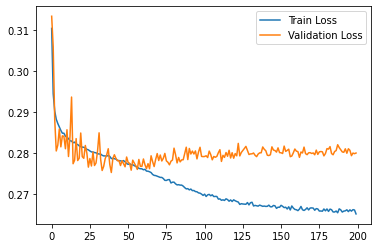

In [20]:
plt.plot(train_running_loss_history, label = 'Train Loss')
plt.plot(validation_running_loss_history, label = 'Validation Loss')
plt.legend()

In [21]:
model.eval()
X_train.size()

torch.Size([1, 1, 572, 572])

In [22]:
out = (y_pred + 0.5).int().float()

In [23]:
print(dice_index(y_train, out))
print(dice_loss(y_train, out))

tensor(0.2216, device='cuda:0')
tensor(0.7784, device='cuda:0')


In [24]:
# pig = plt.figure(figsize = (15, 6))

# a = pig.add_subplot(2, 3, 1)
# plt.imshow(im_converterX(X_train[0]))

# a = pig.add_subplot(2, 3, 2)
# plt.imshow(im_converterY(y_train[0]))

# a = pig.add_subplot(2, 3, 3)
# plt.imshow(im_converterY(out[0]))


# a = pig.add_subplot(2, 3, 4)
# plt.imshow(im_converterX(X_train[1]))

# a = pig.add_subplot(2, 3, 5)
# plt.imshow(im_converterY(y_train[1]))

# a = pig.add_subplot(2, 3, 6)
# plt.imshow(im_converterY(out[1]))

In [25]:
gg = dice_index(out, y_train)
print(gg)
print(dice_loss(out, y_train))

tensor(0.2216, device='cuda:0')
tensor(0.7784, device='cuda:0')


In [26]:
class HC18_test(Dataset):
    def __init__(self, root_dir, transformX = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'test_set_pixel_size.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        
    def __len__(self):
        return len(self.pixel_file)
    
    def __getitem__(self, index):
        imx_name = os.path.join(self.root_dir, 'test_set', self.pixel_file.iloc[index, 0])
        
        imx = Image.open(imx_name)
        
        f_name = self.pixel_file.iloc[index, 0]
        
        if self.transformX :
            imx = self.transformX(imx)
        
        sample = {'image': imx, 'f_name': f_name}
        return sample

In [27]:
test_data = HC18_test('', transformX = tx_X)

In [28]:
test_data

In [29]:
test_loader = DataLoader(dataset = test_data, batch_size = 2, shuffle = True)

In [30]:
test_loader

0 torch.Size([2, 1, 572, 572])


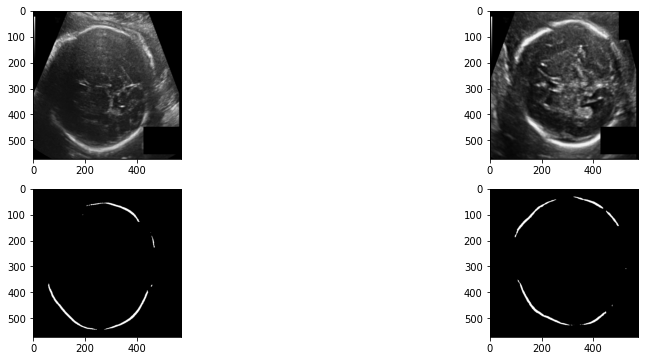

In [31]:
## Here we loop through our train_loader and see the images
## Looks good
fig = plt.figure(figsize = (15,6))
#model.to('cpu')
for ith_batch, sample_batched in enumerate(test_loader):
  
    X_test = sample_batched['image'].to('cuda')
    print(ith_batch, X_test.size())
    
    y_test = (model(X_test) + 0.5).int().float()
    
    
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(X_test[index]))
        
        ax  = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(y_test[index]))
    break

In [32]:
def avg_dice_index(dataloader):
  
    dice = 0.0
    model.eval()
    with torch.no_grad():
    
        for ith_batch, sample_batched in enumerate(dataloader):
  
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['annotation'].to('cuda')
            
            y_predict = (model(X_train) + 0.5).int().float()
            
            dice += dice_index(y_predict, y_train)
            
            
            
    avg_dice = dice / len(dataloader)
    return avg_dice.item()

In [33]:
avg_dice_index(validation_loader)    #### Dice index of validation data

0.16532573103904724

In [34]:
avg_dice_index(train_loader)        ### Dice index of training data

0.21628175675868988

In [35]:
test_loader = DataLoader(dataset = test_data, batch_size = 1, shuffle = True) # to write image files

## **Warning!!!**
### Your are about to write on drive

In [36]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((540, 800)),
        transforms.ToTensor()
        ])
    
with torch.no_grad():
      #model.eval()
      for ith_batch , sample in enumerate(test_loader):
        X_test = sample['image'].to('cuda')
        y_pred = (model(X_test) + 0.5).int().float().cpu()
#         print(335-ith_batch)
        
        file_names = sample['f_name']
        pankaj = transform(y_pred[0])
        #singh = transform(y_pred[1])
        torchvision.utils.save_image(pankaj , os.path.join('segmented', file_names[0]))
        #torchvision.utils.save_image(singh, os.path.join('/content/drive/My Drive/HC18/test_set', file_names[1].replace('.png','_Annotation.png')))
      print("Segmentation files written")
        
        

Segmentation files written


In [37]:
def fit_ellipse(im):    
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [len(contour) for contour in contours]
    ellipse = cv2.fitEllipse(contours[np.argmax(contour_sizes)])
    return ellipse

In [38]:
file_names = sorted([file for _,_,files in os.walk('segmented/') for file in files])

In [39]:
df_pixel_size = pd.read_csv('test_set_pixel_size.csv')
submission = {'filename': [], 'center_x_mm': [], 'center_y_mm': [], 'semi_axes_a_mm': [],
             'semi_axes_b_mm': [], 'angle_rad': [], 'Index': []}

file_names = sorted([file for _,_,files in os.walk('segmented/') for file in files])

for i, file_name in enumerate(file_names):
    im = cv2.imread('segmented/'+file_name)
   # file_name = file_name.replace('_Segmented', '')
    ellipse = fit_ellipse(im)
    im_mask = cv2.ellipse(np.zeros_like(im),ellipse,(255,255,255),-1)
    image_name = file_name.split('.')[0] + '_Annotation_fit.png'
    #cv2.imwrite('/content/drive/My Drive/HC18/test_set/'+image_name, im_mask)
    
    pixel_size = df_pixel_size.loc[df_pixel_size['filename'] == file_name, 'pixel size(mm)'].iloc[0]
    submission['filename'].extend([file_name])
    submission['Index'].extend([int(file_name.split('_')[0])])
    center_x,  center_y = ellipse[0]
    submission['center_x_mm'].extend([pixel_size*center_x])
    submission['center_y_mm'].extend([pixel_size*center_y])
    semi_axes_b, semi_axes_a = ellipse[1]
    if semi_axes_b > semi_axes_a:
        semi_axes_b = semi_axes_b + semi_axes_a
        semi_axes_a = semi_axes_b - semi_axes_a
        semi_axes_b -= semi_axes_a
    submission['semi_axes_a_mm'].extend([semi_axes_a*pixel_size/2])
    submission['semi_axes_b_mm'].extend([semi_axes_b*pixel_size/2])
    angle = ellipse[2]
    if angle < 90:
        angle += 90
    else:
        angle -= 90
    submission['angle_rad'].extend([np.deg2rad(angle)])
    
submission = pd.DataFrame(submission)
submission = submission[['filename', 'center_x_mm', 'center_y_mm', 
                         'semi_axes_a_mm', 'semi_axes_b_mm', 'angle_rad', 'Index']]    
submission = submission.sort_values(['Index'])
submission = submission.drop('Index', axis=1)
submission.to_csv("Unet_GB_31_2.csv", index=False)
print('Required .csv file generated')

Required .csv file generated


In [40]:
q = pd.read_csv('Unet_GB_31_2.csv')  ## to check theck the generated csv

In [41]:
print('Length of csv file: ',len(q))

Length of csv file:  335


In [42]:
submission.head()

,filename,center_x_mm,center_y_mm,semi_axes_a_mm,semi_axes_b_mm,angle_rad
0,000_HC.png,194.795642,1.779668,68.979425,53.092343,1.570796
1,001_HC.png,19.070371,30.721976,4.573091,2.945662,0.773545
2,002_HC.png,99.466882,4.337185,24.713474,20.992861,0.677636
3,003_HC.png,-274.435295,218.109447,334.675386,76.612875,1.570796
4,004_HC.png,82.726423,67.169538,57.601892,35.390451,0.082899
